In [113]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
import matplotlib.pyplot as plt
import pickle




In [114]:
# overview the training data
x_train_df = pd.read_csv(os.path.join('data_reviews', 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join('data_reviews', 'y_train.csv'))

tr_text_list = x_train_df.values.tolist()
tr_y_list = y_train_df.values.tolist()

tr_y = np.hstack(np.array(tr_y_list))


In [115]:
vectorizer = CountVectorizer(strip_accents='ascii', lowercase=True, max_df=0.9)
reviews_list = [val[1] for val in tr_text_list]
vectorizer = vectorizer.fit(reviews_list)

print("Size of Vocab:", len(vectorizer.get_feature_names_out()))

Size of Vocab: 4512


In [116]:
with open('vectorizer1.pkl','wb') as f:
    pickle.dump(vectorizer,f)

In [117]:
def extract_BoW_features(data_list):
    with open('vectorizer1.pkl','rb') as f:
        vectorizer = pickle.load(f)
    reviews_list = [val[1] for val in data_list]
    features_count = vectorizer.transform(reviews_list)
    return features_count

features_count = extract_BoW_features(tr_text_list)

In [118]:
param_grid = {
    'C' : np.logspace(-9, 6, 31),
    'penalty': ['l1', 'l2']
}

In [119]:
lr = sklearn.linear_model.LogisticRegression(solver='liblinear')
# Setup GridSearchCV with AUROC scoring
auroc_scorer = make_scorer(roc_auc_score, needs_proba=True, greater_is_better=True)
grid_search = GridSearchCV(lr, param_grid, scoring=auroc_scorer, cv=5, refit=True, return_train_score=True)

grid_search.fit(features_count, tr_y)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([1.00000000e-09, 3.16227766e-09, 1.00000000e-08, 3.16227766e-08,
       1.00000000e-07, 3.16227766e-07, 1.00000000e-06, 3.16227766e-06,
       1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True,
             scoring=make_scorer(roc_auc_score, needs_proba=True))

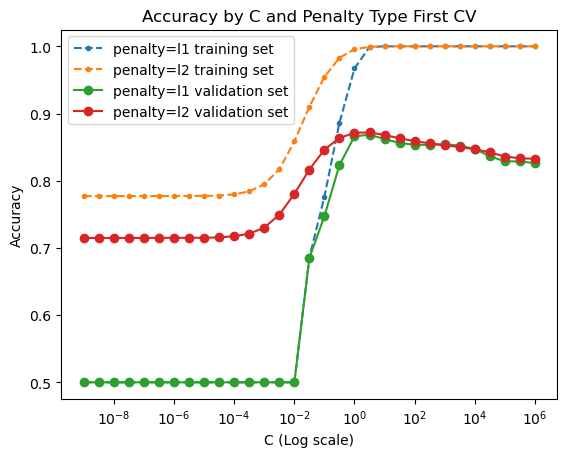

In [120]:
results_df_train = pd.concat([
    pd.DataFrame(grid_search.cv_results_["params"]),
    pd.DataFrame(grid_search.cv_results_["mean_train_score"], columns=["Accuracy"])
], axis=1)

results_df_test = pd.concat([
    pd.DataFrame(grid_search.cv_results_["params"]),
    pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])
], axis=1)

fig, ax = plt.subplots()

for penalty in results_df_train['penalty'].unique():
    subset = results_df_train[results_df_train['penalty'] == penalty]
    ax.plot(subset['C'], subset['Accuracy'], marker='.', linestyle='dashed', label=f'penalty={penalty} training set')

# Loop through each unique penalty type in your results to create a separate line in the plot
for penalty in results_df_test['penalty'].unique():
    subset = results_df_test[results_df_test['penalty'] == penalty]
    ax.plot(subset['C'], subset['Accuracy'], marker='o', label=f'penalty={penalty} validation set')

# Set the x-axis to a logarithmic scale to better visualize the wide range of C values
ax.set_xscale('log')
# Label your axes and create a title
ax.set_xlabel('C (Log scale)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by C and Penalty Type First CV')
# Display a legend to differentiate between penalty types
ax.legend()

# Show the plot
plt.show()

In [121]:
cv_results = grid_search.cv_results_
cv_results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

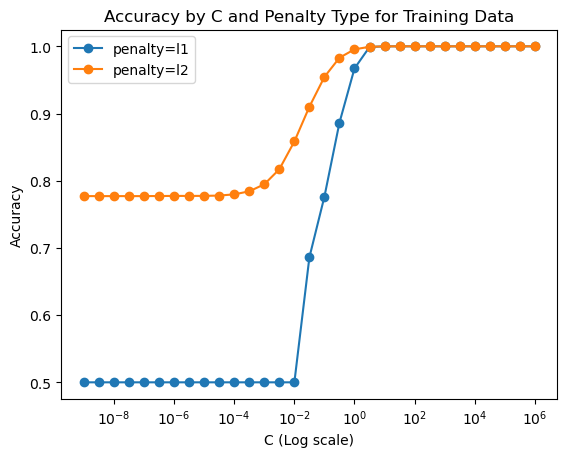

In [122]:


results_df = pd.concat([
    pd.DataFrame(grid_search.cv_results_["params"]),
    pd.DataFrame(grid_search.cv_results_["mean_train_score"], columns=["Accuracy"])
], axis=1)

fig, ax = plt.subplots()

# Loop through each unique penalty type in your results to create a separate line in the plot
for penalty in results_df['penalty'].unique():
    subset = results_df[results_df['penalty'] == penalty]
    ax.plot(subset['C'], subset['Accuracy'], marker='o', label=f'penalty={penalty}')

# Set the x-axis to a logarithmic scale to better visualize the wide range of C values
ax.set_xscale('log')
# Label your axes and create a title
ax.set_xlabel('C (Log scale)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by C and Penalty Type for Training Data')
# Display a legend to differentiate between penalty types
ax.legend()

# Show the plot
plt.show()

In [123]:
print("Best parameters:", grid_search.best_params_)
print("Best AUROC score:", grid_search.best_score_)

# best seen AUROC: 0.8723802083333334

Best parameters: {'C': 3.1622776601683795, 'penalty': 'l2'}
Best AUROC score: 0.87196875


In [124]:
best_C = grid_search.best_params_['C']
new_param_grid = {
    'C' : np.logspace(-1 * best_C, best_C, 51),
    'penalty': ['l1', 'l2']
}
# print(new_param_grid)
new_grid_search = GridSearchCV(lr, new_param_grid, scoring=auroc_scorer, cv=10, refit=True, return_train_score=True)
new_grid_search.fit(features_count, tr_y)



GridSearchCV(cv=10, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([6.88212157e-04, 9.20902064e-04, 1.23226625e-03, 1.64890509e-03,
       2.20641279e-03, 2.95241819e-03, 3.95065384e-03, 5.28640077e-03,
       7.07377417e-03, 9.46547249e-03, 1.26658227e-02, 1.69482363e-02,
       2.26785674e-02, 3.03463682e-02, 4.06067124e-02, 5.43361591e-02,
       7.27076390e-02, 9.72...
       7.68135337e+00, 1.02784790e+01, 1.37537130e+01, 1.84039508e+01,
       2.46264704e+01, 3.29528724e+01, 4.40944960e+01, 5.90031896e+01,
       7.89526290e+01, 1.05647130e+02, 1.41367250e+02, 1.89164621e+02,
       2.53122658e+02, 3.38705406e+02, 4.53224350e+02, 6.06463043e+02,
       8.11512936e+02, 1.08589180e+03, 1.45304030e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True,
             scoring=make_scorer(roc_auc_score, needs_proba=True))

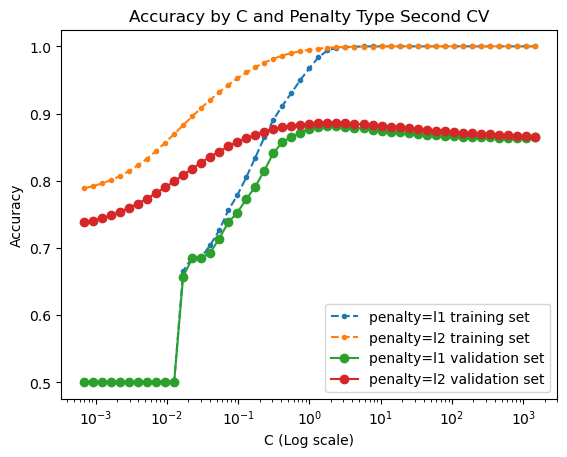

In [125]:
new_grid_search.cv_results_
results_df_train = pd.concat([
    pd.DataFrame(new_grid_search.cv_results_["params"]),
    pd.DataFrame(new_grid_search.cv_results_["mean_train_score"], columns=["Accuracy"])
], axis=1)

results_df_test = pd.concat([
    pd.DataFrame(new_grid_search.cv_results_["params"]),
    pd.DataFrame(new_grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])
], axis=1)

fig, ax = plt.subplots()

for penalty in results_df_train['penalty'].unique():
    subset = results_df_train[results_df_train['penalty'] == penalty]
    ax.plot(subset['C'], subset['Accuracy'], marker='.', linestyle='dashed', label=f'penalty={penalty} training set')

# Loop through each unique penalty type in your results to create a separate line in the plot
for penalty in results_df_test['penalty'].unique():
    subset = results_df_test[results_df_test['penalty'] == penalty]
    ax.plot(subset['C'], subset['Accuracy'], marker='o', label=f'penalty={penalty} validation set')

# Set the x-axis to a logarithmic scale to better visualize the wide range of C values
ax.set_xscale('log')
# Label your axes and create a title
ax.set_xlabel('C (Log scale)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by C and Penalty Type Second CV')
# Display a legend to differentiate between penalty types
ax.legend()

# Show the plot
plt.show()



In [126]:
best_model = new_grid_search.best_estimator_

with open('classifier1.pkl','wb') as f:
    pickle.dump(best_model,f)

In [127]:
# for Part D
from sklearn.model_selection import train_test_split

num_rows = features_count.shape[0]
indices = np.arange(num_rows)

train_indices, val_indices, _, _ = train_test_split(indices, indices, test_size=0.2, random_state=42)

# Now you can use train_indices and val_indices to index your data
X_train = features_count[train_indices]
y_train = tr_y[train_indices]

X_val = features_count[val_indices]
y_val = tr_y[val_indices]

# fit the best model on the test set
model = sklearn.linear_model.LogisticRegression(solver='liblinear', C=new_grid_search.best_params_['C'],  penalty=new_grid_search.best_params_['penalty'])

model.fit(X_train, y_train)
# use the best model, perdict probability on validation set
y_probs = model.predict_proba(X_val)
# print(y_probs[:10])
# print(y_val[:10])

from sklearn.metrics import f1_score, precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs[:,1])
# Calculate F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
# Find the index of the best F1 score
best_index = np.argmax(f1_scores)
# Find the best threshold and F1 score
best_threshold = thresholds[best_index]

from sklearn.metrics import confusion_matrix
binary_predictions = (y_probs[:, 1] >= best_threshold).astype(int)
[[TN, FP], [FN, TP]] = confusion_matrix(y_val, binary_predictions)
print(TN, FP, FN, TP)

tn_indices = val_indices[(binary_predictions == 0) & (y_val == 0)]
fp_indices = val_indices[(binary_predictions == 1) & (y_val == 0)]
fn_indices = val_indices[(binary_predictions == 0) & (y_val == 1)]
tp_indices = val_indices[(binary_predictions == 1) & (y_val == 1)]

tn_texts = [tr_text_list[i][1] for i in tn_indices]
fp_texts = [tr_text_list[i][1] for i in fp_indices]
fn_texts = [tr_text_list[i][1] for i in fn_indices]
tp_texts = [tr_text_list[i][1] for i in tp_indices]

print(len(fp_indices), len(fn_indices))

192 45 28 215
45 28


Mean TN length: 61
Mean FP length: 63
Mean FN length: 59
Mean TP length: 60


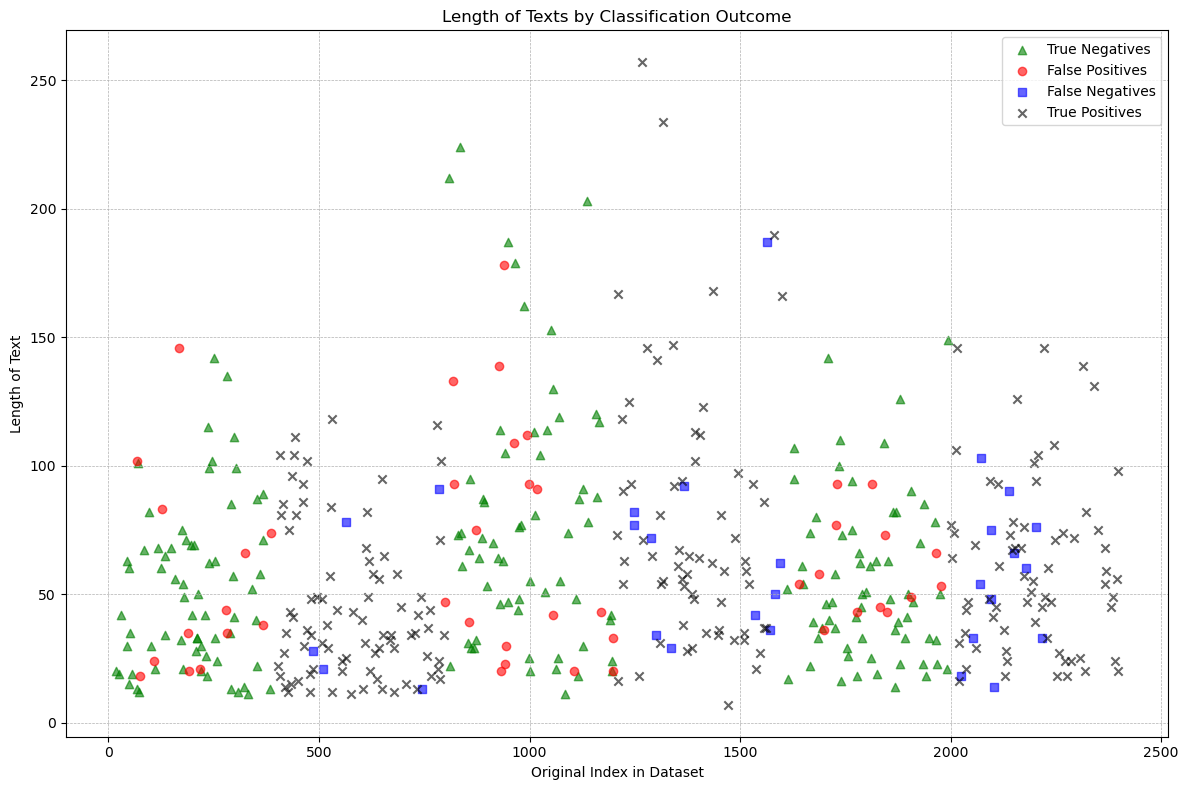

In [128]:
# look at length, kind of review, sentences with negation?

# tr_text_list


tn_lengths = [len(review) for review in tn_texts]
fp_lengths = [len(review) for review in fp_texts]
fn_lengths = [len(review) for review in fn_texts]
tp_lengths = [len(review) for review in tp_texts]

print(f"Mean TN length: {np.mean(tn_lengths):.0f}")
print(f"Mean FP length: {np.mean(fp_lengths):.0f}")
print(f"Mean FN length: {np.mean(fn_lengths):.0f}")
print(f"Mean TP length: {np.mean(tp_lengths):.0f}")

# Plotting
plt.figure(figsize=(12, 8))

# For True Negatives
plt.scatter(tn_indices, tn_lengths, color='green', marker='^', alpha=0.6, label='True Negatives')

# For False Positives
plt.scatter(fp_indices, fp_lengths, color='red', marker='o', alpha=0.6, label='False Positives')

# For False Negatives
plt.scatter(fn_indices, fn_lengths, color='blue', marker='s', alpha=0.6, label='False Negatives')

# For True Positives
plt.scatter(tp_indices, tp_lengths, color='black', marker='x', alpha=0.6, label='True Positives')

plt.xlabel('Original Index in Dataset')
plt.ylabel('Length of Text')
plt.title('Length of Texts by Classification Outcome')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()




In [129]:
# Function to plot data points and a trendline
def plot_with_trendline(indices, lengths, label, color):
    # Scatter plot
    plt.scatter(indices, lengths, label=label, color=color, alpha=0.6)
    
    # Trendline
    z = np.polyfit(indices, lengths, 1)  # Fit a 1st degree polynomial (linear) trendline
    p = np.poly1d(z)
    plt.plot(indices, p(indices), color=color, linestyle='--')  # Plot the trendline

# plt.figure(figsize=(12, 8))

# Plot each set with its trendline
# plot_with_trendline(tn_indices, tn_lengths, 'True Negatives', 'green')
# plot_with_trendline(fp_indices, fp_lengths, 'False Positives', 'red')
# plot_with_trendline(fn_indices, fn_lengths, 'False Negatives', 'blue')
# plot_with_trendline(tp_indices, tp_lengths, 'True Positives', 'black')

# plt.xlabel('Original Index')
# plt.ylabel('Length of Text')
# plt.title('Text Lengths by Classification Outcome with Trendlines')
# plt.legend()
# plt.show()

In [130]:
companies = ['amazon', 'imdb', 'yelp']

# Initialize dictionaries to hold indices for each classification outcome by company
tn_by_company = {company: [] for company in companies}
fp_by_company = {company: [] for company in companies}
fn_by_company = {company: [] for company in companies}
tp_by_company = {company: [] for company in companies}

# Function to categorize indices by company
def categorize_by_company(indices, outcome_dict):
    for index in indices:
        company = tr_text_list[index][0].lower()  # Company is the first element
        outcome_dict[company].append(index)

# Categorize each set of indices by company
categorize_by_company(tn_indices, tn_by_company)
categorize_by_company(fp_indices, fp_by_company)
categorize_by_company(fn_indices, fn_by_company)
categorize_by_company(tp_indices, tp_by_company)

# Now, you can count the number of outcomes for each company
for company in companies:
    print(f"Company {company}:")
    print(f"  True Negatives: {len(tn_by_company[company])}")
    print(f"  False Positives: {len(fp_by_company[company])}")
    print(f"  False Negatives: {len(fn_by_company[company])}")
    print(f"  True Positives: {len(tp_by_company[company])}")
    print()

Company amazon:
  True Negatives: 67
  False Positives: 13
  False Negatives: 5
  True Positives: 83

Company imdb:
  True Negatives: 61
  False Positives: 19
  False Negatives: 11
  True Positives: 64

Company yelp:
  True Negatives: 64
  False Positives: 13
  False Negatives: 12
  True Positives: 68



In [137]:
# Gather counts for each company and outcome
tn_counts = [len(tn_by_company[company]) for company in companies]
fp_counts = [len(fp_by_company[company]) for company in companies]
fn_counts = [len(fn_by_company[company]) for company in companies]
tp_counts = [len(tp_by_company[company]) for company in companies]

total_counts = [len(tn_by_company[company]) + len(fp_by_company[company]) + 
                len(fn_by_company[company]) + len(tp_by_company[company]) for company in companies]

# Calculate percentages for each outcome
tn_percents = [len(tn_by_company[company]) / total * 100 for company, total in zip(companies, total_counts)]
fp_percents = [len(fp_by_company[company]) / total * 100 for company, total in zip(companies, total_counts)]
fn_percents = [len(fn_by_company[company]) / total * 100 for company, total in zip(companies, total_counts)]
tp_percents = [len(tp_by_company[company]) / total * 100 for company, total in zip(companies, total_counts)]

for i, company in enumerate(companies):
    print(company)
    cr = tn_percents[i] + tp_percents[i]
    er = fp_percents[i] + fn_percents[i]
    print("TN + TP", cr)
    print("FP + FN", er)


amazon
TN + TP 89.28571428571429
FP + FN 10.714285714285714
imdb
TN + TP 80.64516129032259
FP + FN 19.35483870967742
yelp
TN + TP 84.07643312101911
FP + FN 15.92356687898089


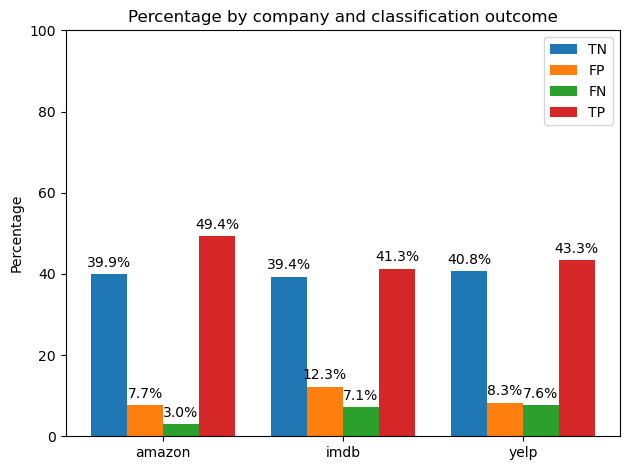

In [138]:
# Set up the bar graph
x = np.arange(len(companies))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*1.5, tn_percents, width, label='TN')
rects2 = ax.bar(x - width/2, fp_percents, width, label='FP')
rects3 = ax.bar(x + width/2, fn_percents, width, label='FN')
rects4 = ax.bar(x + width*1.5, tp_percents, width, label='TP')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentage by company and classification outcome')
ax.set_xticks(x)
ax.set_xticklabels(companies)
ax.set_ylim(0, 100)  # Ensure the y-axis always goes from 0 to 100%
ax.legend()

# Function to attach a text label above each bar, displaying its height
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function for each bar set
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.savefig('perc.png')